In [65]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tensorflow.keras as keras
from tensorflow.keras import Model
# tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

In [16]:
tf.get_logger().setLevel('ERROR')
os.environ['CUDA_VISIBLE_DEVICES'] = '1' # 使用 GPU 1
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0],True)
logical_devices = tf.config.list_logical_devices("GPU")

# 数据集获取

In [17]:
# dataset 使用的是CLUE MRPC dataset
# MRPC数据集的数据是从在线新闻上得到的句子对 人工标注了两个句子在语义上是否等价
# 使用api load下载好的数据
glue, info = tfds.load(name = 'glue/mrpc',
                       data_dir='tensorflow_study/bert_exp/data_dir/tensorflow_datasets',
                       with_info=True,
                       download=False,
                       batch_size=-1)

In [18]:
# ---------------------------------------------------------------------------------------------------------------------------
# 使用TFRecordDataset load数据
train_dataset = tf.data.TFRecordDataset('tensorflow_study/bert_exp/data_dir/mrpc/glue-train.tfrecord-00000-of-00001')
valid_dataset = tf.data.TFRecordDataset('tensorflow_study/bert_exp/data_dir/mrpc/glue-validation.tfrecord-00000-of-00001')
test_dataset = tf.data.TFRecordDataset('tensorflow_study/bert_exp/data_dir/mrpc/glue-test.tfrecord-00000-of-00001')

In [19]:
for i in train_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(i.numpy())
    print(example)

features {
  feature {
    key: "idx"
    value {
      int64_list {
        value: 1680
      }
    }
  }
  feature {
    key: "label"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "sentence1"
    value {
      bytes_list {
        value: "The identical rovers will act as robotic geologists , searching for evidence of past water ."
      }
    }
  }
  feature {
    key: "sentence2"
    value {
      bytes_list {
        value: "The rovers act as robotic geologists , moving on six wheels ."
      }
    }
  }
}



In [20]:
feature_description = {
    'idx': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'label': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'sentence1': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'sentence2': tf.io.FixedLenFeature([], tf.string, default_value=''),
}
def _parse_function(example_proto):
  # Parse the input `tf.Example` proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)

parsed_dataset = train_dataset.map(_parse_function)

In [21]:
for i in parsed_dataset.take(1):
    print(i)

{'idx': <tf.Tensor: shape=(), dtype=int64, numpy=1680>, 'label': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'sentence1': <tf.Tensor: shape=(), dtype=string, numpy=b'The identical rovers will act as robotic geologists , searching for evidence of past water .'>, 'sentence2': <tf.Tensor: shape=(), dtype=string, numpy=b'The rovers act as robotic geologists , moving on six wheels .'>}


In [22]:
# -----------------------------------------------------------------------------------------------------------------

In [23]:
print(type(glue))
print(glue.keys())
# 下载的数据集有train validation test三种

<class 'dict'>
dict_keys(['train', 'validation', 'test'])


In [24]:
print(type(info))
print(info.features)
# 每个数据有四个feature idx label sentence1 sentence2
print(info.features['label'].names)
# label 0-1 对应了 不相关和相关

<class 'tensorflow_datasets.core.dataset_info.DatasetInfo'>
FeaturesDict({
    'idx': tf.int32,
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'sentence1': Text(shape=(), dtype=tf.string),
    'sentence2': Text(shape=(), dtype=tf.string),
})
['not_equivalent', 'equivalent']


In [25]:
glue_train = glue['train']
glue_valid = glue['validation']
glue_test = glue['test']

In [26]:
glue_train['sentence1']

<tf.Tensor: shape=(3668,), dtype=string, numpy=
array([b'The identical rovers will act as robotic geologists , searching for evidence of past water .',
       b"Less than 20 percent of Boise 's sales would come from making lumber and paper after the OfficeMax purchase is completed .",
       b'Spider-Man snatched $ 114.7 million in its debut last year and went on to capture $ 403.7 million .',
       ...,
       b'Stack said he did no work for Triumph until 1999 , when a grand jury began investigating Silvester .',
       b'The giant rock was first observed on August 24 by Lincoln Near-Earth Asteroid Research Program , based in Socorro , New Mexico .',
       b"Two of Collins ' top assistants will consult with state police during the investigation and determine if any federal laws were violated , he said Friday ."],
      dtype=object)>

In [27]:
for key, value in glue_train.items():
    print(f"{key:9s}: {value[0].numpy()}")

idx      : 1680
label    : 0
sentence1: b'The identical rovers will act as robotic geologists , searching for evidence of past water .'
sentence2: b'The rovers act as robotic geologists , moving on six wheels .'


In [28]:
# 加载bert
# preprocessor = hub.KerasLayer(
#     "https://hub.tensorflow.google.cn/tensorflow/bert_en_cased_preprocess/3")
# encoder = hub.KerasLayer(
#     "https://hub.tensorflow.google.cn/tensorflow/bert_en_cased_L-12_H-768_A-12/4",
#     trainable=True)

# BERT Tokenizer
将输入的sentence1 sentence2变为input_word_ids, input_mask, input_type_ids

In [29]:
# BERT tokenizer
# 需要保证对token的处理和bert pre-train时一样

# method1 bert的preprocessor直接做 (2 sentences直接用preprocessor做似乎做不了?)
# preprocessor.call(glue_train[glue_train])

In [30]:
# method2 使用official.nlp库原生加入[CLS] [SOS] [EOS] [PAD]

tokenizer = bert.tokenization.FullTokenizer(
    vocab_file='tensorflow_study/bert_exp/model_dir/imdb_bert/assets/vocab.txt', # 指定vocab_file
    do_lower_case=True
)
print('vocab size: ', len(tokenizer.vocab)) # vocab词表有30522个token

vocab size:  30522


In [31]:
tokens = tokenizer.tokenize('I love tensorflow! I also love pytorch!') # 使用tokenize进行分词 应该是sentencepiece的方法
print(tokens)
print(type(tokens))
ids = tokenizer.convert_tokens_to_ids(tokens) # 将token变成数字id
print(ids)

['i', 'love', 'tensor', '##flow', '!', 'i', 'also', 'love', 'p', '##yt', '##or', '##ch', '!']
<class 'list'>
[1045, 2293, 23435, 12314, 999, 1045, 2036, 2293, 1052, 22123, 2953, 2818, 999]


In [32]:
# 在当前这个BERT任务中 必须要[CLS]用来表示分类 [SEP]用来分隔两个句子
tokenizer.convert_tokens_to_ids(['[CLS]','[SEP]']) # 特定的[CLS]  [SEP] 对应101 102

[101, 102]

In [33]:
def encode_sentence(s):
    tokens_ = list(tokenizer.tokenize(s.numpy())) # 将 tf.string的tensor转化为numpy 再tokenize 变成sub-word的list
    tokens_.append('[SEP]') # 在末尾加上[SEP]
    return tokenizer.convert_tokens_to_ids(tokens_) # 将加了[SEP]的tokens转化为id

sentence1 = tf.ragged.constant([encode_sentence(s1) for s1 in glue_train['sentence1']])
sentence2 = tf.ragged.constant([encode_sentence(s2) for s2 in glue_train['sentence2']]) # 因为不同句子长度不一样 所以是ragged的tensor
print(sentence1.shape)
print(sentence2.shape)
# shape第一维都是3668代表句子个数 但是第二维None是因为不同的句子维度不同 所以无法显式表示

(3668, None)
(3668, None)


In [34]:
print('raw_sentence1_test : ', str(glue_train['sentence1'][0].numpy(), encoding = 'utf8'))
print('after encode : ', sentence1[0])
print('after encode shape: ', sentence1[0].shape)

raw_sentence1_test :  The identical rovers will act as robotic geologists , searching for evidence of past water .
after encode :  tf.Tensor(
[ 1996  7235  9819  2097  2552  2004 20478 21334  2015  1010  6575  2005
  3350  1997  2627  2300  1012   102], shape=(18,), dtype=int32)
after encode shape:  (18,)


In [35]:
# 给句子加上[CLS] 并和sentence1和sentence2拼接起来[CLS] [SENTENCE1] [SEP] [SENTENCE2] [SEP]
cls_token = tokenizer.convert_tokens_to_ids(['[CLS]'])
cls_token = tf.constant(cls_token)
cls = [cls_token] * sentence1.shape[0] # 将CLS的is 重复句子个数次
input_word_ids = tf.concat([cls, sentence1, sentence2], axis=1)
print('sentence1 ids:', sentence1[0])
print('sentence2 ids:', sentence2[0])
print('concat: ', input_word_ids[0])
# 两个句子拼在一起 开头加上了[CLS]

sentence1 ids: tf.Tensor(
[ 1996  7235  9819  2097  2552  2004 20478 21334  2015  1010  6575  2005
  3350  1997  2627  2300  1012   102], shape=(18,), dtype=int32)
sentence2 ids: tf.Tensor(
[ 1996  9819  2552  2004 20478 21334  2015  1010  3048  2006  2416  7787
  1012   102], shape=(14,), dtype=int32)
concat:  tf.Tensor(
[  101  1996  7235  9819  2097  2552  2004 20478 21334  2015  1010  6575
  2005  3350  1997  2627  2300  1012   102  1996  9819  2552  2004 20478
 21334  2015  1010  3048  2006  2416  7787  1012   102], shape=(33,), dtype=int32)


<class 'tensorflow.python.ops.ragged.ragged_tensor.RaggedTensor'>


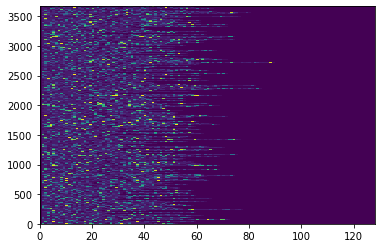

In [36]:
print(type(input_word_ids))
# raggedTensor使用to_tensor方法 不指定维度就是填充到最大长度 指定维度就是pad或截断到指定维度
_ = plt.pcolormesh(input_word_ids.to_tensor(shape=(sentence1.shape[0], 128)))

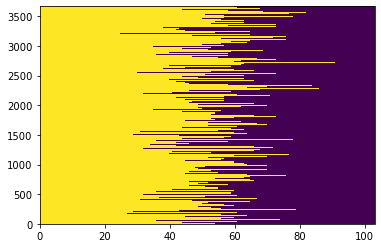

In [37]:
# bert要接收的输入还要有input mask和input type - 这和preprocess的结果一样
# input mask生成
input_mask_ragged = tf.ones_like(input_word_ids) # ones_like就将input_word_ids的位置有值变为1 生成了raggedTensor
input_mask = input_mask_ragged.to_tensor() # to_tensor 进行pad
plt.pcolormesh(input_mask)

In [38]:
# input type生成 input_type用0和1代表句子的部分 cls和s1是0 s2是1

type_cls = tf.zeros_like(cls)
type_sentence1 = tf.zeros_like(sentence1)
type_sentence2 = tf.ones_like(sentence2)
input_type_ragged = tf.concat([type_cls, type_sentence1, type_sentence2], axis=-1)
input_type_tensor = input_type_ragged.to_tensor()
input_type_tensor[0]
# 前面用0表示cls + sentence1 后面用1表示sentence2 之后再用0表示

<tf.Tensor: shape=(103,), dtype=int32, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>

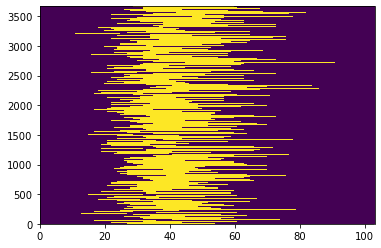

In [39]:
plt.pcolormesh(input_type_tensor)

In [40]:
## 数据处理部分

def encode(tokenizer, one_sentence):
    """
    将一个sentence转化为id表示 tokenize -> +[SEP] -> to_ids
    :param one_sentence:
    :param tokenizer:
    :return:
    """
    tokens_int_list = list(tokenizer.tokenize(one_sentence.numpy()))
    tokens_int_list.append('[SEP]')
    return tokenizer.convert_tokens_to_ids(tokens_int_list)

def raw_token_to_input(tokenizer,glue_set):
    """
    对glue_set生成input_word_ids, input_mask input_type
    :param tokenizer: bert的tokenizer
    :param glue_set: train valid test
    :return: input_word_ids, input_mask, input_type
    """
    # step1 [SEP]转为ids表示
    s1 = tf.ragged.constant([encode(tokenizer,each_s1) for each_s1 in glue_set['sentence1']])
    s2 = tf.ragged.constant([encode(tokenizer,each_s2) for each_s2 in glue_set['sentence2']])

    # step2 加上[CLS]和padding
    cls_id = tokenizer.convert_tokens_to_ids(['[CLS]'])
    cls_id = tf.constant(cls_id)
    cls = [cls_id] * s1.shape[0]
    input_word_ids_ragged = tf.concat([cls, s1, s2], axis=-1)
    input_word_ids = input_word_ids_ragged.to_tensor()

    # step3 生成input mask
    input_mask_ragged = tf.ones_like(input_word_ids_ragged)
    input_mask = input_mask_ragged.to_tensor()

    # step4 生成 input type
    cls_type = tf.zeros_like(cls)
    s1_type = tf.zeros_like(s1)
    s2_type = tf.ones_like(s2)
    input_type_ragged = tf.concat([cls_type, s1_type, s2_type], axis=-1)
    input_type = input_type_ragged.to_tensor()

    inputs = {
        'input_word_ids':input_word_ids,
        'input_mask':input_mask,
        'input_type_ids':input_type
    }

    return inputs

In [41]:
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file='tensorflow_study/bert_exp/model_dir/imdb_bert/assets/vocab.txt', # 指定vocab_file
    do_lower_case=True
)
glue_train_input = raw_token_to_input(tokenizer, glue_set=glue_train)
glue_valid_input = raw_token_to_input(tokenizer, glue_set=glue_valid)
glue_test_input = raw_token_to_input(tokenizer, glue_set=glue_test)

In [42]:
glue_train_labels = glue_train['label']
glue_valid_labels = glue_valid['label']
glue_test_labels = glue_test['label']

In [43]:
for key, value in glue_train_input.items():
    print(f'{key} shape {value.shape}' )

print('glue_train_labels_shape: ', glue_train_labels.shape)

input_word_ids shape (3668, 103)
input_mask shape (3668, 103)
input_type_ids shape (3668, 103)
glue_train_labels_shape:  (3668,)


In [73]:
glue_train_input.keys()

dict_keys(['input_word_ids', 'input_mask', 'input_type_ids'])

# 模型

In [59]:
encoder = hub.KerasLayer(
    "https://hub.tensorflow.google.cn/tensorflow/bert_en_cased_L-12_H-768_A-12/3",
    trainable=True)

In [60]:
result = encoder(dict(input_word_ids = glue_train_input['input_word_ids'][:10],
                              input_mask = glue_train_input['input_mask'][:10],
                              input_type_ids = glue_train_input['input_type_ids'][:10]),
                 training = False
                 )

In [67]:
result.keys()

dict_keys(['sequence_output', 'pooled_output', 'default', 'encoder_outputs'])

In [68]:
print('pooled output shape', result['pooled_output'].shape)
print('sequence output shape: ', result['sequence_output'].shape)

pooled output shape (10, 768)
sequence output shape:  (10, 103, 768)


In [66]:
class MRPCModel(Model):
    def __init__(self, encoder, dropout = 0.1):
        super(MRPCModel, self).__init__()
        self.dropout = dropout
        self.encoder = encoder
        self.dropout_layer = keras.layers.Dropout(self.dropout)
        self.output_proj = keras.layers.Dense(units=2, activation='sigmoid', name='classifier')

    def call(self, inputs, training=None, mask=None):
        # input有三个部分 input_word_ids input_mask input_type_ids 都是[batch, seq_len]

        encoded = self.encoder(inputs)
        # 包含了pooled_output encoder_outputs sequence_output
        x = encoded['pooled_output']
        # [batch, hidden] pooled_output将整个句子表示为一个向量 没有seq_len
        x = self.dropout_layer(x)
        y = self.output_proj(x)
        # [batch, 2]
        return y

In [69]:
mrpcModel = MRPCModel(encoder)

In [85]:
small_batch = {key: val[:3] for key, val in glue_train_input.items()}

In [82]:
test_result = mrpcModel(small_batch)

In [83]:
test_result

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0.70050156, 0.9201527 ],
       [0.72920656, 0.93006706],
       [0.7249865 , 0.928551  ]], dtype=float32)>

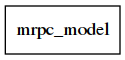

In [84]:
keras.utils.plot_model(mrpcModel)

In [86]:
epochs = 3
batch_size = 32
eval_batch_size = 32

In [89]:
train_data_size = len(glue_train_labels)       # data_size
step_per_epoch = train_data_size // batch_size # data_size // batch_size是更新的step次数
num_train_steps = step_per_epoch * epochs      # step次数乘以epochs 得到的是总的训练过程的step数
warmup_steps = int(num_train_steps * 0.1)      # 10% 的部分用warmup

In [91]:
optimizer = nlp.optimization.create_optimizer(
    init_lr = 2e-5,
    num_train_steps=num_train_steps,
    num_warmup_steps=warmup_steps
)

In [92]:
type(optimizer)
# 是AdamW优化器

official.nlp.optimization.AdamWeightDecay

In [93]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metrics = [keras.metrics.SparseCategoricalCrossentropy('accuracy')]

In [94]:
mrpcModel.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
)

In [95]:
mrpcModel.fit(x=glue_train_input,y=glue_train_labels,validation_data=(glue_valid_input, glue_valid_labels),batch_size=batch_size,epochs=epochs)

Epoch 1/3
115/115 [==============================] - 36s 178ms/step - loss: 0.6192 - accuracy: 0.6192 - val_loss: 0.4865 - val_accuracy: 0.4865
Epoch 2/3
115/115 [==============================] - 20s 172ms/step - loss: 0.4856 - accuracy: 0.4856 - val_loss: 0.4773 - val_accuracy: 0.4773
Epoch 3/3
115/115 [==============================] - 20s 173ms/step - loss: 0.3862 - accuracy: 0.3862 - val_loss: 0.5063 - val_accuracy: 0.5063


In [107]:
# 模型测试
my_examples = raw_token_to_input(
    tokenizer=tokenizer,
    glue_set = {
        'sentence1':[
            tf.constant('The rain in Spain falls mainly on the plain.'),
            tf.constant('Look I fine tuned BERT.')],
        'sentence2':[
            tf.constant('It mostly rains on the flat lands of Spain.'),
            tf.constant('Is it working? This does not match.')]
    },)

In [108]:
my_examples

{'input_word_ids': <tf.Tensor: shape=(2, 23), dtype=int32, numpy=
 array([[  101,  1996,  4542,  1999,  3577,  4212,  3701,  2006,  1996,
          5810,  1012,   102,  2009,  3262, 15811,  2006,  1996,  4257,
          4915,  1997,  3577,  1012,   102],
        [  101,  2298,  1045,  2986, 15757, 14324,  1012,   102,  2003,
          2009,  2551,  1029,  2023,  2515,  2025,  2674,  1012,   102,
             0,     0,     0,     0,     0]], dtype=int32)>,
 'input_mask': <tf.Tensor: shape=(2, 23), dtype=int32, numpy=
 array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
         0]], dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(2, 23), dtype=int32, numpy=
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
         0]], dtype=int32)>}

In [109]:
example_result = mrpcModel(my_examples)

In [114]:
classify_result = tf.argmax(example_result)
classify_result
# 第一个sentence1和sentence2对模型预测是等价的
# 第二个sentence1和sentence2对模型预测是不等价的

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([1, 0])>

# 保存模型

In [115]:
model_dir = 'tensorflow_study/bert_exp/model_dir/MRPC_bert/saved_model'
tf.saved_model.save(mrpcModel, export_dir=model_dir)

In [116]:
# 加载模型
reloaded = tf.saved_model.load(export_dir=model_dir)
reloaded

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7fe3429993a0>

In [142]:
# reloaded期待一个103维的矩阵 可能是之前输入的时候没做好
reloaded(my_examples)

ValueError: Could not find matching concrete function to call loaded from the SavedModel. Got:
  Positional arguments (3 total):
    * {'input_word_ids': <tf.Tensor 'inputs_2:0' shape=(2, 23) dtype=int32>, 'input_mask': <tf.Tensor 'inputs:0' shape=(2, 23) dtype=int32>, 'input_type_ids': <tf.Tensor 'inputs_1:0' shape=(2, 23) dtype=int32>}
    * False
    * None
  Keyword arguments: {}

 Expected these arguments to match one of the following 4 option(s):

Option 1:
  Positional arguments (3 total):
    * {'input_type_ids': TensorSpec(shape=(None, 103), dtype=tf.int32, name='input_type_ids'), 'input_word_ids': TensorSpec(shape=(None, 103), dtype=tf.int32, name='input_word_ids'), 'input_mask': TensorSpec(shape=(None, 103), dtype=tf.int32, name='input_mask')}
    * False
    * None
  Keyword arguments: {}

Option 2:
  Positional arguments (3 total):
    * {'input_type_ids': TensorSpec(shape=(None, 103), dtype=tf.int32, name='inputs/input_type_ids'), 'input_word_ids': TensorSpec(shape=(None, 103), dtype=tf.int32, name='inputs/input_word_ids'), 'input_mask': TensorSpec(shape=(None, 103), dtype=tf.int32, name='inputs/input_mask')}
    * False
    * None
  Keyword arguments: {}

Option 3:
  Positional arguments (3 total):
    * {'input_type_ids': TensorSpec(shape=(None, 103), dtype=tf.int32, name='inputs/input_type_ids'), 'input_mask': TensorSpec(shape=(None, 103), dtype=tf.int32, name='inputs/input_mask'), 'input_word_ids': TensorSpec(shape=(None, 103), dtype=tf.int32, name='inputs/input_word_ids')}
    * True
    * None
  Keyword arguments: {}

Option 4:
  Positional arguments (3 total):
    * {'input_type_ids': TensorSpec(shape=(None, 103), dtype=tf.int32, name='input_type_ids'), 'input_word_ids': TensorSpec(shape=(None, 103), dtype=tf.int32, name='input_word_ids'), 'input_mask': TensorSpec(shape=(None, 103), dtype=tf.int32, name='input_mask')}
    * True
    * None
  Keyword arguments: {}

In [130]:
my_examples_input_word_ids = my_examples['input_word_ids']
my_examples_input_word_ids

<tf.Tensor: shape=(2, 23), dtype=int32, numpy=
array([[  101,  1996,  4542,  1999,  3577,  4212,  3701,  2006,  1996,
         5810,  1012,   102,  2009,  3262, 15811,  2006,  1996,  4257,
         4915,  1997,  3577,  1012,   102],
       [  101,  2298,  1045,  2986, 15757, 14324,  1012,   102,  2003,
         2009,  2551,  1029,  2023,  2515,  2025,  2674,  1012,   102,
            0,     0,     0,     0,     0]], dtype=int32)>

In [135]:
# 只好通过pad_sequences pad到103维
my_examples_input_word_ids_padded = tf.constant(keras.preprocessing.sequence.pad_sequences(my_examples_input_word_ids, maxlen=103, padding='post'))
my_examples_input_word_ids_padded

<tf.Tensor: shape=(2, 103), dtype=int32, numpy=
array([[  101,  1996,  4542,  1999,  3577,  4212,  3701,  2006,  1996,
         5810,  1012,   102,  2009,  3262, 15811,  2006,  1996,  4257,
         4915,  1997,  3577,  1012,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0],
       [  101,  2298,  1045,  2986, 15757, 14324,  1012,   102,  2003,
         2009,  2551,  1029,  2023,  2515,  2025,  2674,  1012,

In [136]:
my_examples_input_mask = my_examples['input_mask']
my_examples_input_type_ids = my_examples['input_type_ids']

In [137]:
my_examples_input_mask_padded = tf.constant(keras.preprocessing.sequence.pad_sequences(my_examples_input_mask, maxlen=103, padding='post'))
my_examples_input_type_ids_padded = tf.constant(keras.preprocessing.sequence.pad_sequences(my_examples_input_type_ids, maxlen=103, padding='post'))

In [138]:
my_examples_padded = {
    'input_word_ids':my_examples_input_word_ids_padded,
    'input_mask':my_examples_input_mask_padded,
    'input_type_ids':my_examples_input_type_ids_padded
}

In [140]:
reloaded_result = reloaded(my_examples_padded)

In [141]:
# 可以看到reloaded和raw结果完全相同
print('reloaded_result: ', reloaded_result)
print('raw_result: ',example_result)

reloaded_result:  tf.Tensor(
[[0.6414739  0.70649564]
 [0.65445554 0.52771413]], shape=(2, 2), dtype=float32)
raw_result:  tf.Tensor(
[[0.641412   0.70646423]
 [0.6544158  0.5276735 ]], shape=(2, 2), dtype=float32)


# 针对大型数据集的encoding
上述教程由于数据集很小 是在内存中进行的dataset的处理 re-encoded
而针对于大型的数据集，在内存中进行re-encoded是不合适的
使用tf_models库的一些方法 高效地处理大型dataset

**由于网络问题 这部分先没做**

In [146]:
# step1 确定哪些feature是需要encoded
processor = nlp.data.classifier_data_lib.TfdsProcessor(
    tfds_params="dataset=glue/mrpc,text_key=sentence1,text_b_key=sentence2",
    process_text_fn=bert.tokenization.convert_to_unicode)
# 这个方法接收一个tfds的参数 和process_text_fn 第二个参数传入的是bert.tokenization的方法

ConnectionError: HTTPSConnectionPool(host='firebasestorage.googleapis.com', port=443): Max retries exceeded with url: /v0/b/mtl-sentence-representations.appspot.com/o/data%2Fmrpc_dev_ids.tsv?alt=media&token=ec5c0836-31d5-48f4-b431-7480817f1adc (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fe34057ab20>: Failed to establish a new connection: [Errno 110] Connection timed out'))

In [ ]:
# step2 将encode方法应用在数据集上产生TFRecord files
# 所以这是最核心的一步 用其定义的方法直接对数据进行处理并生成TFRecord files
# 似乎很能节省内存资源

train_data_output_path="./mrpc_train.tf_record"
eval_data_output_path="./mrpc_eval.tf_record"
# 目标文件位置

max_seq_length = 128
batch_size = 32
eval_batch_size = 32

input_meta_data = (
    nlp.data.classifier_data_lib.generate_tf_record_from_data_file(
      processor=processor,      # 使用上面定义的processor
      data_dir=None,            # data_dir是None因为文件时从tfds获得 而非本地
      tokenizer=tokenizer,
      train_data_output_path=train_data_output_path,
      eval_data_output_path=eval_data_output_path,
      max_seq_length=max_seq_length))

In [ ]:
# step3加载TFRecord files
training_dataset = bert.run_classifier.get_dataset_fn(
    train_data_output_path,
    max_seq_length,
    batch_size,
    is_training=True)()

evaluation_dataset = bert.run_classifier.get_dataset_fn(
    eval_data_output_path,
    max_seq_length,
    eval_batch_size,
    is_training=False)()
# 载入TFRecord files数据

In [ ]:
# 不使用库函数get_dataset_fn
# 原生生成tf.data.Dataset

def create_classifier_dataset(file_path, seq_length, batch_size, is_training):
  dataset = tf.data.TFRecordDataset(file_path)
  # 加载TFRecordDataset
  if is_training:
    dataset = dataset.shuffle(100)
    dataset = dataset.repeat()

  def decode_record(record):
    name_to_features = {
      'input_ids': tf.io.FixedLenFeature([seq_length], tf.int64),
      'input_mask': tf.io.FixedLenFeature([seq_length], tf.int64),
      'segment_ids': tf.io.FixedLenFeature([seq_length], tf.int64),
      'label_ids': tf.io.FixedLenFeature([], tf.int64),
    }
    # 使用tf.io.FixedLenFeature定义要解析的内容
    return tf.io.parse_single_example(record, name_to_features)
    # 使用tf.io.parse_single_example进行解析TFRecord对象

  def _select_data_from_record(record):
    x = {
        'input_word_ids': record['input_ids'],
        'input_mask': record['input_mask'],
        'input_type_ids': record['segment_ids']
    }
    y = record['label_ids']
    return (x, y)
    # 分出x y

  dataset = dataset.map(decode_record,
                        num_parallel_calls=tf.data.AUTOTUNE)
  # 现在dataset变成了四个tensor
  dataset = dataset.map(
      _select_data_from_record,
      num_parallel_calls=tf.data.AUTOTUNE)
  # 现在dataset变成了x y
  dataset = dataset.batch(batch_size, drop_remainder=is_training)
  dataset = dataset.prefetch(tf.data.AUTOTUNE)
  return dataset

# Set up batch sizes
batch_size = 32
eval_batch_size = 32

# Return Tensorflow dataset
training_dataset = create_classifier_dataset(
    train_data_output_path,
    input_meta_data['max_seq_length'],
    batch_size,
    is_training=True)

evaluation_dataset = create_classifier_dataset(
    eval_data_output_path,
    input_meta_data['max_seq_length'],
    eval_batch_size,
    is_training=False)

# AdamW

In [148]:
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)
type(optimizer)
# 这是之前使用的optimizer 类型是AdamW

official.nlp.optimization.AdamWeightDecay

In [151]:
print('num_train_steps: ', num_train_steps)
print('warmup_steps: ', warmup_steps)

num_train_steps:  342
warmup_steps:  34


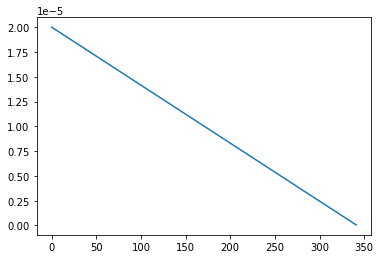

In [149]:
# 原生的AdamW
decay_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
      initial_learning_rate=2e-5,
      decay_steps=num_train_steps,
      end_learning_rate=0)

plt.plot([decay_schedule(n) for n in range(num_train_steps)])
# 使用PolynomialDecay 可以看到学习率在接近num_train_steps后下降为0

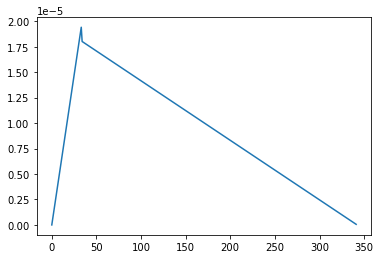

In [152]:
warmup_schedule = nlp.optimization.WarmUp(
        initial_learning_rate=2e-5,
        decay_schedule_fn=decay_schedule,
        warmup_steps=warmup_steps)
plt.plot([warmup_schedule(n) for n in range(num_train_steps)])
# 使用warmup + decay_schedule就可以看到先warmup再decay的结果